# Figures of Merit plots

In [4]:
import h5py
import numpy as np
import glob
import json
import os
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
from ipywidgets import Dropdown, FloatSlider, HBox, Output, interact, widgets
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from common import CosmoInt
# Disable LaTeX rendering to avoid dependency issues in Binder
# plt.rcParams['text.usetex'] = False

plt.style.use('science')

# plot_params = {
#     "figure.dpi": "300",
#     "axes.labelsize": 20,
#     "axes.linewidth": 1.5,
#     "axes.titlesize": 20,
#     "xtick.labelsize": 16,
#     "ytick.labelsize": 16,
#     "legend.title_fontsize": 16,
#     "legend.fontsize": 16,
#     "xtick.major.size": 3.5,
#     "xtick.major.width": 1.5,
#     "xtick.minor.size": 2.5,
#     "xtick.minor.width": 1.5,
#     "ytick.major.size": 3.5,
#     "ytick.major.width": 1.5,
#     "ytick.minor.size": 2.5,
#     "ytick.minor.width": 1.5,
# }


# plt.rcParams.update(plot_params)

## Electromagnetic Observations and LVK detections

<>:46: SyntaxWarning: invalid escape sequence '\&'
<>:46: SyntaxWarning: invalid escape sequence '\&'
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_21546/3148655577.py:46: SyntaxWarning: invalid escape sequence '\&'
  ax.plot(z_qpe, masses_qpe, 'D', color='purple', markersize=6, label='QPE \& QPO')


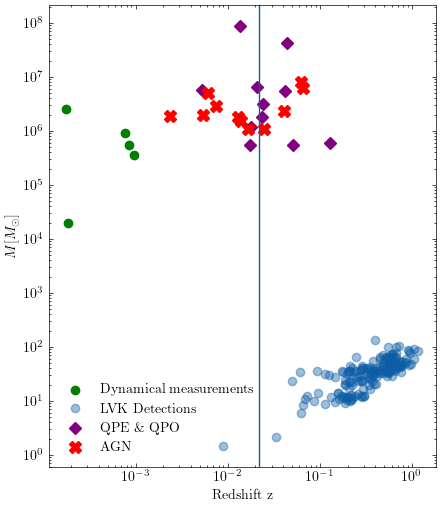

In [5]:
# from 2020ARA&A..58..257G
# Data for green circles
# The `green_points` dictionary contains data points represented by green circles in a plot. Each key in the dictionary corresponds to the name of the data point, and the value associated with each key is a tuple containing the distance (`d`) and mass (`m`) of the data point. These data points are plotted as green circles on the graph with the specified distance and mass values, along with the corresponding name displayed next to the circle.
green_points = { # distance in Mpc, mass in solar masses https://arxiv.org/pdf/1911.09678 Figure 2
    'M32': (0.785, 2.5e6), #  Nguyen+2019
    'N5102': (3.4, 9e5), # Nguyen+2019
    'N5206': (3.8, 5.4e5), # Nguyen+2019
    'N4395': (4.3, 3.6e5), # den Brok+2015
    'N205': (0.824, 2e4), # Nguyen+2019
}

fig, ax = plt.subplots(figsize=(5, 6))

# Plot green circles
z_dyn, m_dyn = np.asarray([(CosmoInt.get_redshift(d/1e3), m) for name, (d, m) in green_points.items()]).T

# LVK
with open('lvk_gw_events.json', 'r') as f:
    data_lvk = json.load(f)

# https://arxiv.org/pdf/2404.00941
masses_qpe = np.asarray([1.2, 0.55, 0.55, 3.1, 42.5, 1.8, 5.5, 0.595, 6.55, 88.0, 5.8]) * 1e6
z_qpe     = np.asarray([0.0181, 0.0505, 0.0175, 0.024, 0.044, 0.0237, 0.042, 0.13, 0.0206, 0.0136, 0.0053])
d_qpe = CosmoInt.get_luminosity_distance(z_qpe)

# Data extracted from Table EM_measure arXiv-2501.03252v2
smbh_data = [
        {"name": "UGC 01032", "mass": 1.1, "redshift": 0.01678, "alternate_names": "Mrk 359"},
        {"name": "UGC 12163", "mass": 1.1, "redshift": 0.02468, "alternate_names": "Ark 564"},
        {"name": "Swift J2127.4+5654", "mass": 1.5, "redshift": 0.01400, "alternate_names": ""},
        {"name": "NGC 4253", "mass": 1.8, "redshift": 0.01293, "alternate_names": "UGC 07344, Mrk 766"},
        {"name": "NGC 4051", "mass": 1.91, "redshift": 0.00234, "alternate_names": "UGC 07030"},
        {"name": "NGC 1365", "mass": 2.0, "redshift": 0.00545, "alternate_names": ""},
        {"name": "1H0707-495", "mass": 2.3, "redshift": 0.04056, "alternate_names": ""},
        {"name": "MCG-6-30-15", "mass": 2.9, "redshift": 0.00749, "alternate_names": ""},
        {"name": "NGC 5506", "mass": 5.0, "redshift": 0.00608, "alternate_names": "Mrk 1376"},
        {"name": "IRAS13224-3809", "mass": 6.3, "redshift": 0.06579, "alternate_names": ""},
        {"name": "Ton S180", "mass": 8.1, "redshift": 0.06198, "alternate_names": ""},
    ]
smbh_masses = np.array([item['mass'] for item in smbh_data]) * 1e6
smbh_redshifts = np.array([item['redshift'] for item in smbh_data])
smbh_distances = CosmoInt.get_luminosity_distance(smbh_redshifts)

ax.scatter(z_dyn, m_dyn, marker='o', color='green', label='Dynamical measurements')
ax.plot(data_lvk['redshift'],data_lvk['primary_mass'],'o', alpha=0.4, label='LVK Detections')
ax.plot(z_qpe, masses_qpe, 'D', color='purple', markersize=6, label='QPE \& QPO')
ax.plot(smbh_redshifts, smbh_masses, 'X', color='red', markersize=8, label='AGN')

# Set scales and limits
ax.set_xscale('log')
ax.set_yscale('log')

ax.axvline(0.022)
# Labels
ax.set_xlabel('Redshift z')
ax.set_ylabel(r'$M [M_{\odot}]$')
ax.legend(loc='lower left')
plt.savefig('current_observations.png', dpi=400)

## Load and Organize Detection Data from All Sources

In [6]:
# Load all detection.h5 files from snr_* directories
detection_files = sorted(glob.glob('snr_*/detection.h5'))
print(f"Found {len(detection_files)} detection.h5 files")

# Dictionary to store data indexed by source_id
source_metadata = {}
source_snr_data = {}

for idx, det_file in enumerate(detection_files):
    source_id = int(det_file.split('_')[1].split('/')[0])
    print(f"Loading source {idx+1}/{len(detection_files)}: {det_file} (ID={source_id})")
    
    with h5py.File(det_file, 'r') as f:
        # Extract scalar metadata
        source_metadata[source_id] = {
            'm1': float(np.round(f['m1'][()], decimals=5)),
            'm2': float(np.round(f['m2'][()], decimals=5)),
            'a': float(np.round(f['a'][()], decimals=5)),
            'p0': float(f['p0'][()]),
            'e0': float(f['e0'][()]),
            'T': float(np.round(f['Tpl'][()], decimals=5)),  # Tpl value
        }
        
        # Extract SNR data as function of redshift
        # snr shape: (10 redshifts, 100 realizations)
        snr_data = f['snr'][()]  # (10, 100)
        redshifts = f['redshift'][()]  # (10,)
        dist = f['dist'][()]  # (10,)
        
        # Store SNR data indexed by redshift
        source_snr_data[source_id] = {}
        for z_idx, z_val in enumerate(redshifts):
            source_snr_data[source_id][float(z_val)] = snr_data[z_idx, :]

print("\nData loading complete!")
print(f"Loaded metadata for {len(source_metadata)} sources")
print(f"Loaded SNR data for {len(source_snr_data)} sources")

Found 58 detection.h5 files
Loading source 1/58: snr_0/detection.h5 (ID=0)
Loading source 2/58: snr_1/detection.h5 (ID=1)
Loading source 3/58: snr_10/detection.h5 (ID=10)
Loading source 4/58: snr_11/detection.h5 (ID=11)
Loading source 5/58: snr_12/detection.h5 (ID=12)
Loading source 6/58: snr_13/detection.h5 (ID=13)
Loading source 7/58: snr_14/detection.h5 (ID=14)
Loading source 8/58: snr_15/detection.h5 (ID=15)
Loading source 9/58: snr_16/detection.h5 (ID=16)
Loading source 10/58: snr_17/detection.h5 (ID=17)
Loading source 11/58: snr_18/detection.h5 (ID=18)
Loading source 12/58: snr_19/detection.h5 (ID=19)
Loading source 13/58: snr_2/detection.h5 (ID=2)
Loading source 14/58: snr_20/detection.h5 (ID=20)
Loading source 15/58: snr_21/detection.h5 (ID=21)
Loading source 16/58: snr_22/detection.h5 (ID=22)
Loading source 17/58: snr_23/detection.h5 (ID=23)
Loading source 18/58: snr_24/detection.h5 (ID=24)
Loading source 19/58: snr_25/detection.h5 (ID=25)
Loading source 20/58: snr_26/detectio

Detection Volume: 73.66640177471513 Gpc^3


/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_21546/4115144306.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  det_Volume = np.trapz(pdet_interp(np.log10(z_)) * dVc / (1+z_), z_)


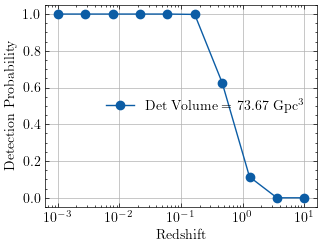

In [7]:
from common import ref_cosmo
source_id = 0
plt.figure()
red_, pdet = np.asarray([[key,np.sum(np.asarray(item)>30.)/len(item)] for key,item in source_snr_data[source_id].items()]).T
# interpolate pdet
pdet_interp = interp1d(np.log10(red_), pdet, kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
# comoving volume
z_ = np.logspace(-3, 1, 1000)
Vc = np.asarray(ref_cosmo.comoving_volume(z_)) * (1e-3)**3 # = Gpc^3
# differential comoving volume
dVc = np.gradient(Vc, z_)
det_Volume = np.trapz(pdet_interp(np.log10(z_)) * dVc / (1+z_), z_)
print(f"Detection Volume: {det_Volume} Gpc^3")
plt.semilogx(red_, pdet, 'o-', label=f'Det Volume = {det_Volume:.2f} Gpc$^3$')

plt.xlabel("Redshift")
plt.ylabel("Detection Probability")
plt.grid()
plt.legend()
plt.show()


In [8]:
# Extract unique parameter values for dropdowns
Tpl_values = sorted(set(source_metadata[src]['T'] for src in source_metadata))
a_values = sorted(set(source_metadata[src]['a'] for src in source_metadata))
m1_values = sorted(set(source_metadata[src]['m1'] for src in source_metadata))
m2_values = sorted(set(source_metadata[src]['m2'] for src in source_metadata))

# Collect all unique redshifts across all sources
all_redshifts = set()
for src_id in source_snr_data:
    all_redshifts.update(source_snr_data[src_id].keys())
all_redshifts = sorted(all_redshifts)

print(f"Unique Tpl values: {Tpl_values}")
print(f"Unique spin (a) values: {a_values}")
print(f"Number of unique redshifts: {len(all_redshifts)}")
print(f"Redshift range: {min(all_redshifts):.6f} to {max(all_redshifts):.6f}")

print(f"Unique m1 values: {m1_values}")
print(f"Unique m2 values: {m2_values}")

Unique Tpl values: [0.25, 1.5, 4.5]
Unique spin (a) values: [-0.99, 0.99]
Number of unique redshifts: 10
Redshift range: 0.001000 to 10.000000
Unique m1 values: [50000.0, 100000.0, 1000000.0, 10000000.0]
Unique m2 values: [1.0, 5.0, 10.0, 50.0, 100.0, 1000.0, 10000.0]


## Interactive Degradation Analysis Plots
Adjust the sliders and dropdowns to see how detector degradation affects SNR and redshift reach. The degradation factor $d$ on the spectral density $S_n(f)\rightarrow \, d \, S_n(f) $ scales the SNR as $\text{SNR}_{\text{degraded}} = \text{SNR}_{\text{original}} / \sqrt{d}$.
<!-- This notebook analyzes the impact of detector degradation on SNR and redshift reach for EMRI sources. The degradation factor $d$ is applied as: $\text{SNR}_{\text{degraded}} = \text{SNR}_{\text{original}} / \sqrt{d}$ -->

In [9]:
# Create dropdowns for Tpl, spin, redshift, and degradation
tpl_dropdown_deg = Dropdown(
    options=[(f'Tpl = {t:.2f}', t) for t in Tpl_values],
    description='Tpl:',
    value=Tpl_values[0]
)

spin_dropdown_deg = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values],
    description='Spin (a):',
    value=a_values[-1]
)

redshift_dropdown_deg = Dropdown(
    options=[(f'z = {z:.6f}', z) for z in all_redshifts],
    description='Redshift:',
    value=all_redshifts[3]
)

# SNR threshold slider for redshift plot in degradation analysis
snr_threshold_slider = widgets.FloatSlider(
    value=30,
    min=5,
    max=100,
    step=5,
    description='SNR threshold:',
    continuous_update=True
)

degradation_slider = widgets.FloatSlider(
    value=2.0,
    min=1.0,
    max=3.0,
    step=0.25,
    description='Degradation (d):',
    continuous_update=True
)


m2_filter_dropdown = Dropdown(
    options=[('All', 'all')] + [(f'm2 = {m2:.0f}', m2) for m2 in sorted(m2_values)],
    description='Secondary mass:',
    value='all'
)

output_deg_plot = Output()

# Plot styling variables for double-column PRD-style papers
savefig_name = 'snr_redshift_vs_m1.png'
save_figure = True

In [10]:
estimator = np.median

In [11]:

def plot_degradation_effect(tpl_val, spin_a, z_val, snr_threshold, degradation, m2_filter):
    """
    Plot showing degradation effect on SNR and redshift.
    Top: SNR vs m1 with arrows showing degradation impact
    Bottom: Redshift vs m1 with arrows showing degradation impact
    """
    tolerance = 1e-6
    matching_sources = []
    
    # Filter sources by Tpl and spin
    for src_idx in sorted(source_metadata.keys()):
        src_a = source_metadata[src_idx]['a']
        src_tpl = source_metadata[src_idx]['T']
        
        if abs(src_a - spin_a) < tolerance and abs(src_tpl - tpl_val) < tolerance:
            matching_sources.append(src_idx)
    
    if not matching_sources:
        with output_deg_plot:
            output_deg_plot.clear_output(wait=True)
            print(f"No sources found for Tpl={tpl_val:.2f}, a={spin_a:.2f}")
        return
    
    # Extract SNR data for specified redshift
    snr_data = {}
    for src_idx in matching_sources:
        m1 = source_metadata[src_idx]['m1']
        m2 = source_metadata[src_idx]['m2']
        
        if z_val not in source_snr_data[src_idx]:
            continue
            
        snr_array = source_snr_data[src_idx][z_val]  # Shape: (100,)
        snr_median = estimator(snr_array)
        
        if m2 not in snr_data:
            snr_data[m2] = {'m1': [], 'snr_orig': []}
        snr_data[m2]['m1'].append(m1)
        snr_data[m2]['snr_orig'].append(snr_median)
    
    # Extract redshift reach data
    z_data = {}
    for src_idx in matching_sources:
        m1 = source_metadata[src_idx]['m1']
        m2 = source_metadata[src_idx]['m2']
        
        # Get SNR vs redshift
        z_snr_dict = source_snr_data[src_idx]
        z_vals_list = sorted(z_snr_dict.keys())
        snr_median_per_z = []
        
        for z in z_vals_list:
            snr_array = z_snr_dict[z]
            snr_median_per_z.append(np.median(snr_array))
        
        snr_median_per_z = np.array(snr_median_per_z)
        z_vals_array = np.array(z_vals_list)
        
        if snr_threshold > np.max(snr_median_per_z):
            continue
        
        try:
            # Original redshift at SNR threshold
            interp_func = interp1d(snr_median_per_z, z_vals_array, kind='linear',
                                   bounds_error=False, fill_value='extrapolate')
            z_at_snr = interp_func(snr_threshold)
            
            # Degraded SNR values
            snr_median_per_z_deg = snr_median_per_z / np.sqrt(degradation)
            interp_func_deg = interp1d(snr_median_per_z_deg, z_vals_array, kind='linear',
                                       bounds_error=False, fill_value='extrapolate')
            z_at_snr_deg = interp_func_deg(snr_threshold)
        except:
            continue
        
        if m2 not in z_data:
            z_data[m2] = {'m1': [], 'z_orig': [], 'z_deg': []}
        z_data[m2]['m1'].append(m1)
        z_data[m2]['z_orig'].append(z_at_snr)
        z_data[m2]['z_deg'].append(z_at_snr_deg)
    
    # Create figure with two subplots
    with output_deg_plot:
        output_deg_plot.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,4.5), sharex=True)
        
        colors = plt.cm.tab20(np.linspace(0, 1, max(len(snr_data), len(z_data)) or 1))
        
        # TOP PLOT: SNR vs m1 with degradation arrows
        for idx, m2 in enumerate(sorted(snr_data.keys())):
            # Filter by m2 if user selected specific value
            if m2_filter != 'all' and m2 != m2_filter:
                continue
            
            m1_vals = np.array(snr_data[m2]['m1'])
            snr_orig = np.array(snr_data[m2]['snr_orig'])
            snr_deg = snr_orig / np.sqrt(degradation)
            
            sort_idx = np.argsort(m1_vals)
            m1_sorted = m1_vals[sort_idx]
            snr_orig_sorted = snr_orig[sort_idx]
            snr_deg_sorted = snr_deg[sort_idx]
            
            # Plot original and degraded SNR
            ax1.plot(m1_sorted, snr_orig_sorted, 'o-', color=colors[idx],
                    markersize=7, linewidth=1.5, label=f'{m2:.0f}', alpha=0.7)
            ax1.plot(m1_sorted, snr_deg_sorted, 's--', color=colors[idx],
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw downward arrows showing degradation
            for i in range(len(m1_sorted)):
                ax1.annotate('', xy=(m1_sorted[i], snr_deg_sorted[i]),
                           xytext=(m1_sorted[i], snr_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=colors[idx],
                                         lw=1.5, alpha=0.6))
        
        # ax1.set_xlabel('Primary Mass m1 ($M_\\odot$)', fontsize=18)
        ax1.set_ylabel(rf'SNR at $z={z_val:.3f}$')
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major')
        

        leg1 = ax1.legend(loc='upper center',
                          #bbox_to_anchor=(0.5, 1.0), 
                          ncols=4, frameon=True, title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        
        # Second legend for line styles
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, loc='lower left', frameon=True)
        ax1.add_artist(leg2)
        if m2_filter == 'all':
            ax1.set_ylim(1, 1e5)
        
        # ax1.legend(fontsize=fontsize_legend, loc='upper center', bbox_to_anchor=(1.25, 0.99), ncols=1, frameon=True, title='$m_2 [M_\odot]$')
        # ax1.set_title(f'SNR Degradation | Tpl={tpl_val:.2f}, a={spin_a:.2f}, z={z_val:.6f}\nd={degradation:.1f}', fontsize=18, fontweight='bold')
        # ax1.legend(fontsize=9, loc='upper right')
        
        # BOTTOM PLOT: Redshift vs m1 with degradation arrows
        for idx, m2 in enumerate(sorted(z_data.keys())):
            # Filter by m2 if user selected specific value
            if m2_filter != 'all' and m2 != m2_filter:
                continue
            
            m1_vals = np.array(z_data[m2]['m1'])
            z_orig = np.array(z_data[m2]['z_orig'])
            z_deg = np.array(z_data[m2]['z_deg'])
            
            sort_idx = np.argsort(m1_vals)
            m1_sorted = m1_vals[sort_idx]
            z_orig_sorted = z_orig[sort_idx]
            z_deg_sorted = z_deg[sort_idx]
            
            # Plot original and degraded redshift
            ax2.plot(m1_sorted, z_orig_sorted, 'o-', color=colors[idx],
                    markersize=7, linewidth=1.5, label=f'm2={m2:.0f}', alpha=0.7)
            ax2.plot(m1_sorted, z_deg_sorted, 's--', color=colors[idx],
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw upward arrows
            for i in range(len(m1_sorted)):
                ax2.annotate('', xy=(m1_sorted[i], z_deg_sorted[i]),
                           xytext=(m1_sorted[i], z_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=colors[idx],
                                         lw=1.5, alpha=0.6))
        
        ax2.set_xlabel(r'Primary mass $m_1 [M_\odot]$')
        ax2.set_ylabel(f'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$')
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
        
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=f'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax2.legend(handles=legend_elements, loc='lower left', frameon=True)
        ax2.add_artist(leg2)
        
        # ax2.set_title(f'Redshift Loss | SNR threshold={snr_threshold:.1f}, d={degradation:.1f}', fontsize=18, fontweight='bold')
        # ax2.legend(fontsize=9, loc='upper right')
        if m2_filter == 'all':
            ax2.set_ylim(5e-3, None)
        plt.tight_layout()
        # plt.savefig(savefig_name, dpi=300) if save_figure else None
        plt.show()

<>:173: SyntaxWarning: invalid escape sequence '\m'
<>:173: SyntaxWarning: invalid escape sequence '\m'
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_21546/4240641866.py:173: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel(f'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$')


In [12]:
# Create and display widget
controls_deg = HBox([tpl_dropdown_deg, spin_dropdown_deg, redshift_dropdown_deg, 
                     snr_threshold_slider, degradation_slider, m2_filter_dropdown])
display(controls_deg)
display(output_deg_plot)

# Create interactive plot
_ = interact(plot_degradation_effect, tpl_val=tpl_dropdown_deg,
             spin_a=spin_dropdown_deg, z_val=redshift_dropdown_deg,
             snr_threshold=snr_threshold_slider, degradation=degradation_slider,
             m2_filter=m2_filter_dropdown)

Output()

interactive(children=(Dropdown(description='Tpl:', options=(('Tpl = 0.25', 0.25), ('Tpl = 1.50', 1.5), ('Tpl =…

## Paper Plots

In [13]:
def plot_degradation_effect(tpl_val, spin_a, z_val, snr_threshold, degradation, m2_filter, plot_type):
    """
    Plot showing degradation effect on SNR and redshift.
    Can plot either:
    - SNR vs m1 at fixed redshift (plot_type='snr_at_z')
    - Redshift vs m1 at fixed SNR threshold (plot_type='z_at_snr')
    """
    tolerance = 1e-6
    matching_sources = []
    
    # Filter sources by Tpl and spin
    for src_idx in sorted(source_metadata.keys()):
        src_a = source_metadata[src_idx]['a']
        src_tpl = source_metadata[src_idx]['T']
        
        if abs(src_a - spin_a) < tolerance and abs(src_tpl - tpl_val) < tolerance:
            matching_sources.append(src_idx)
    
    if not matching_sources:
        with output_deg_plot:
            output_deg_plot.clear_output(wait=True)
            print(f"No sources found for Tpl={tpl_val:.2f}, a={spin_a:.2f}")
        return
    
    # Extract SNR data for specified redshift (for SNR vs m1 plot)
    snr_data = {}
    for src_idx in matching_sources:
        m1 = source_metadata[src_idx]['m1']
        m2 = source_metadata[src_idx]['m2']
        
        if z_val not in source_snr_data[src_idx]:
            continue
            
        snr_array = source_snr_data[src_idx][z_val]  # Shape: (100,)
        snr_median = estimator(snr_array)
        
        if m2 not in snr_data:
            snr_data[m2] = {'m1': [], 'snr_orig': []}
        snr_data[m2]['m1'].append(m1)
        snr_data[m2]['snr_orig'].append(snr_median)
    
    # Extract redshift reach data (for redshift vs m1 plot)
    z_data = {}
    for src_idx in matching_sources:
        m1 = source_metadata[src_idx]['m1']
        m2 = source_metadata[src_idx]['m2']
        
        # Get SNR vs redshift
        z_snr_dict = source_snr_data[src_idx]
        z_vals_list = sorted(z_snr_dict.keys())
        snr_median_per_z = []
        
        for z in z_vals_list:
            snr_array = z_snr_dict[z]
            snr_median_per_z.append(np.median(snr_array))
        
        snr_median_per_z = np.array(snr_median_per_z)
        z_vals_array = np.array(z_vals_list)
        
        if snr_threshold > np.max(snr_median_per_z):
            continue
        
        try:
            # Original redshift at SNR threshold
            interp_func = interp1d(snr_median_per_z, z_vals_array, kind='linear',
                                   bounds_error=False, fill_value='extrapolate')
            z_at_snr = interp_func(snr_threshold)
            
            # Degraded SNR values
            snr_median_per_z_deg = snr_median_per_z / np.sqrt(degradation)
            interp_func_deg = interp1d(snr_median_per_z_deg, z_vals_array, kind='linear',
                                       bounds_error=False, fill_value='extrapolate')
            z_at_snr_deg = interp_func_deg(snr_threshold)
        except:
            continue
        
        if m2 not in z_data:
            z_data[m2] = {'m1': [], 'z_orig': [], 'z_deg': []}
        z_data[m2]['m1'].append(m1)
        z_data[m2]['z_orig'].append(z_at_snr)
        z_data[m2]['z_deg'].append(z_at_snr_deg)
    
    # Create figure based on selected plot type
    with output_deg_plot:
        output_deg_plot.clear_output(wait=True)
        fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
        
        colors = plt.cm.tab20(np.linspace(0, 1, max(len(snr_data), len(z_data)) or 1))
        legend_elements = []
        if plot_type == 'snr_at_z':
            # PLOT: SNR vs m1 at fixed redshift with degradation arrows
            for idx, m2 in enumerate(sorted(snr_data.keys())):
                # Filter by m2 if user selected specific value
                if m2_filter != 'all' and m2 != m2_filter:
                    continue
                
                m1_vals = np.array(snr_data[m2]['m1'])
                snr_orig = np.array(snr_data[m2]['snr_orig'])
                snr_deg = snr_orig / np.sqrt(degradation)
                
                sort_idx = np.argsort(m1_vals)
                m1_sorted = m1_vals[sort_idx]
                snr_orig_sorted = snr_orig[sort_idx]
                snr_deg_sorted = snr_deg[sort_idx]
                
                # Plot original and degraded SNR
                ax1.plot(m1_sorted, snr_orig_sorted, 'o-', color=colors[idx],
                        markersize=7, linewidth=1.5, label=f'{m2:.0f}', alpha=0.7)
                ax1.plot(m1_sorted, snr_deg_sorted, 's--', color=colors[idx],
                        markersize=6, linewidth=1.5, alpha=0.5)
                
                # Draw downward arrows showing degradation
                for i in range(len(m1_sorted)):
                    ax1.annotate('', xy=(m1_sorted[i], snr_deg_sorted[i]),
                               xytext=(m1_sorted[i], snr_orig_sorted[i]),
                               arrowprops=dict(arrowstyle='->', color=colors[idx],
                                             lw=1.5, alpha=0.6))
            
            ax1.set_ylabel(rf'SNR at redshift $z={z_val:.3f}$')
            ax1.set_yscale('log')
            
        else:  # plot_type == 'z_at_snr'
            # PLOT: Redshift vs m1 at fixed SNR threshold with degradation arrows
            for idx, m2 in enumerate(sorted(z_data.keys())):
                # Filter by m2 if user selected specific value
                if m2_filter != 'all' and m2 != m2_filter:
                    continue
                
                m1_vals = np.array(z_data[m2]['m1'])
                z_orig = np.array(z_data[m2]['z_orig'])
                z_deg = np.array(z_data[m2]['z_deg'])
                
                sort_idx = np.argsort(m1_vals)
                m1_sorted = m1_vals[sort_idx]
                z_orig_sorted = z_orig[sort_idx]
                z_deg_sorted = z_deg[sort_idx]
                
                # Plot original and degraded redshift
                ax1.plot(m1_sorted, z_orig_sorted, 'o-', color=colors[idx],
                        markersize=7, linewidth=1.5, label=f'{m2:.0f}', alpha=0.7)
                ax1.plot(m1_sorted, z_deg_sorted, 's--', color=colors[idx],
                        markersize=6, linewidth=1.5, alpha=0.5)
                
                # Draw downward arrows showing redshift loss
                for i in range(len(m1_sorted)):
                    ax1.annotate('', xy=(m1_sorted[i], z_deg_sorted[i]),
                               xytext=(m1_sorted[i], z_orig_sorted[i]),
                               arrowprops=dict(arrowstyle='->', color=colors[idx],
                                             lw=1.5, alpha=0.6))
            
            ax1.set_ylabel(f'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$')
            ax1.set_yscale('log')
            # EM
            mask = masses_qpe<=1e7
            ax1.plot(masses_qpe[mask], z_qpe[mask], 'D', color='purple', markersize=6, label='QPE and QPO')
            ax1.plot(smbh_masses, smbh_redshifts, 'X', color='k', markersize=8, label='AGN')
            legend_elements += [
                Line2D([0], [0], marker='D', label='QPE and QPO', markerfacecolor='purple', markersize=6, linestyle='None', color='purple'),
                Line2D([0], [0], marker='X', label='AGN', markerfacecolor='k', markersize=8, linestyle='None', color='k')
                ]
            leg2 = ax1.legend(handles=legend_elements,frameon=True)
            ax1.add_artist(leg2)
            legend_elements = []
        

        
        ax1.set_xlabel(r'Primary mass $m_1 [M_\odot]$')
        ax1.set_xscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major')
        
        legend_elements += [Line2D([0], [0], marker='o', label=f'$m_2 = ${m2:.0f}', markersize=7, linestyle='-', color=colors[idx]) for idx, m2 in enumerate(sorted(snr_data.keys() if plot_type == 'snr_at_z' else z_data.keys())) if (m2_filter == 'all' or m2 == m2_filter)]
        # leg1 = ax1.legend(loc='upper center', ncols=3, frameon=True, 
        #                  title=r'Secondary mass $m_2 [M_\odot]$')
        # ax1.add_artist(leg1)
        
        # Second legend for line styles
        legend_elements += [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, bbox_to_anchor=(1.00, 1.2),
                        #   loc='upper left', 
                          frameon=True, ncols=3)
        # ax1.add_artist(leg2)
        plt.tight_layout()
        plt.savefig(plot_type + '.png',dpi=400)
        print("Plot saved", plot_type + '.png')
        

<>:151: SyntaxWarning: invalid escape sequence '\m'
<>:151: SyntaxWarning: invalid escape sequence '\m'
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_21546/3115687675.py:151: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel(f'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$')


In [14]:
# Create plot type selector
plot_type_dropdown = Dropdown(
    options=[
        ('SNR at given redshift', 'snr_at_z'),
        ('Redshift at given SNR', 'z_at_snr')
    ],
    description='Plot type:',
    value='snr_at_z'
)

# Create and display widget
controls_deg = HBox([tpl_dropdown_deg, spin_dropdown_deg, redshift_dropdown_deg, 
                     snr_threshold_slider, degradation_slider, m2_filter_dropdown, plot_type_dropdown])
display(controls_deg)

# Create interactive plot
_ = interact(plot_degradation_effect, tpl_val=tpl_dropdown_deg,
             spin_a=spin_dropdown_deg, z_val=redshift_dropdown_deg,
             snr_threshold=snr_threshold_slider, degradation=degradation_slider,
             m2_filter=m2_filter_dropdown, plot_type=plot_type_dropdown)

interactive(children=(Dropdown(description='Tpl:', options=(('Tpl = 0.25', 0.25), ('Tpl = 1.50', 1.5), ('Tpl =…

In [16]:
# Create global m2 colorscheme for consistent coloring across all plots
all_m2_values_global = sorted(m2_values)
m2_colors_global = plt.cm.tab20(np.linspace(0, 1, len(all_m2_values_global)))
m2_to_color_global = {m2: m2_colors_global[idx] for idx, m2 in enumerate(all_m2_values_global)}

In [67]:
print("choose z_target from ", list(source_snr_data[0].keys()))

choose z_target from  [0.001, 0.002782559402207126, 0.00774263682681127, 0.021544346900318832, 0.05994842503189409, 0.1668100537200059, 0.4641588833612777, 1.2915496650148826, 3.5938136638046254, 10.0]


<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
<>:15: SyntaxWarning: invalid escape sequence '\o'
<>:16: SyntaxWarning: invalid escape sequence '\o'
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_21546/2026807072.py:15: SyntaxWarning: invalid escape sequence '\o'
  spin_configs = [(0.99, 'Prograde $a=+0.99$, $m_2=1M_\odot$, T=0.25 yr', 'P', z_target_prograde),
/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_21546/2026807072.py:16: SyntaxWarning: invalid escape sequence '\o'
  (-0.99, 'Retrograde $a=-0.99$, $m_2=1M_\odot$, T=0.25 yr', 'X', z_target_retrograde)]


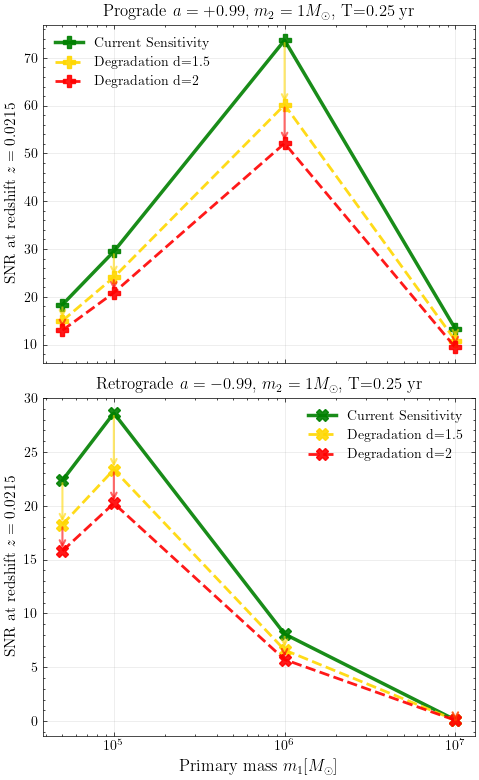

In [85]:
# Plot SNR vs m1 with degradation arrows for m2=1 and Tpl=0.25
# Two subplots: prograde on top, retrograde below, with shared x-axis
# Allow different z_target for prograde and retrograde
# Distinguish prograde (P marker) from retrograde (X marker) using same green color
# Show two degradation levels: d=1.5 (yellow) and d=2.0 (red)
# Red arrow starts from gold SNR
m2_target = 1
Tpl_target = 0.25
z_target_prograde = 0.021544346900318832
z_target_retrograde =  0.021544346900318832 # Change this to use different z for retrograde
tolerance = 1e-6

fig, axes = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

spin_configs = [(0.99, 'Prograde $a=+0.99$, $m_2=1M_\odot$, T=0.25 yr', 'P', z_target_prograde), 
                (-0.99, 'Retrograde $a=-0.99$, $m_2=1M_\odot$, T=0.25 yr', 'X', z_target_retrograde)]
base_color = 'green'
degradation_colors = {1.5: 'gold', 2.0: 'red'}

for ax_idx, (spin_a, spin_label, marker, z_target) in enumerate(spin_configs):
    ax = axes[ax_idx]
    
    # Get luminosity distance for this z
    target_lumdist = dist[list(source_snr_data[0].keys()).index(z_target)]
    
    # Find all sources for this spin with matching m2 and Tpl
    matching_sources = []
    for src_idx in sorted(source_metadata.keys()):
        src_a = source_metadata[src_idx]['a']
        src_m2 = source_metadata[src_idx]['m2']
        src_Tpl = source_metadata[src_idx]['T']
        
        if (abs(src_a - spin_a) < tolerance and 
            abs(src_m2 - m2_target) < 0.01 and 
            abs(src_Tpl - Tpl_target) < 0.01):
            matching_sources.append(src_idx)
    
    if not matching_sources:
        continue
    
    # Extract SNR data at z
    m1_list = []
    snr_list = []
    
    for src_idx in matching_sources:
        if z_target not in source_snr_data[src_idx]:
            continue
            
        m1 = source_metadata[src_idx]['m1']
        snr_array = source_snr_data[src_idx][z_target]
        snr_median = estimator(snr_array)
        
        m1_list.append(m1)
        snr_list.append(snr_median)
    
    # Sort by m1
    if m1_list and snr_list:
        sort_idx = np.argsort(m1_list)
        m1_sorted = np.array(m1_list)[sort_idx]
        snr_sorted = np.array(snr_list)[sort_idx]
        
        # Plot original SNR
        ax.plot(m1_sorted, snr_sorted, marker=marker, color=base_color, markersize=9, 
                linewidth=2.5, alpha=0.9, linestyle='-',
                label=f'Current Sensitivity')
        
        # First degradation level (d=1.5, yellow)
        snr_deg_1_5 = snr_sorted / np.sqrt(1.5)
        ax.plot(m1_sorted, snr_deg_1_5, marker=marker, color='gold', markersize=8, 
                linewidth=2, alpha=0.9, linestyle='--',
                label=f'Degradation d=1.5')
        
        # Draw arrows from original to d=1.5
        for i in range(len(m1_sorted)):
            ax.annotate('', xy=(m1_sorted[i], snr_deg_1_5[i]),
                       xytext=(m1_sorted[i], snr_sorted[i]),
                       arrowprops=dict(arrowstyle='->', color='gold',
                                     lw=1.5, alpha=0.6))
        
        # Second degradation level (d=2.0, red) - starts from d=1.5
        snr_deg_2_0 = snr_sorted / np.sqrt(2.0)
        ax.plot(m1_sorted, snr_deg_2_0, marker=marker, color='red', markersize=8, 
                linewidth=2, alpha=0.9, linestyle='--',
                label=f'Degradation d=2')
        
        # Draw arrows from d=1.5 to d=2.0
        for i in range(len(m1_sorted)):
            ax.annotate('', xy=(m1_sorted[i], snr_deg_2_0[i]),
                       xytext=(m1_sorted[i], snr_deg_1_5[i]),
                       arrowprops=dict(arrowstyle='->', color='red',
                                     lw=1.5, alpha=0.6))

    ax.set_ylabel(f'SNR at redshift $z={z_target:.4f}$', fontsize=11) # , $d_L={target_lumdist:.3f}$ Gpc
    ax.set_title(f'{spin_label}', fontsize=12, fontweight='bold')
    # ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10, loc='best')

# Shared x-axis label at bottom
axes[-1].set_xlabel(r'Primary mass $m_1 [M_\odot]$', fontsize=12)
axes[0].set_xscale('log')

# plt.suptitle(f'SNR vs $m_1$ with Degradation Effects ($m_2={m2_target}$, $T_{{pl}}={Tpl_target}$)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('snr_degradation_m2_1_Tpl_0.25_prograde_retrograde.png', dpi=300, bbox_inches='tight')
plt.show()

# Mission lifetime

In [23]:
# Create dropdowns for Tpl parameter space plot
m1_filtered = [m1 for m1 in sorted(m1_values) if m1 in [1e6, 1e7]]

m1_dropdown_tpl = Dropdown(
    options=[(f'm1 = {m1:.0e}', m1) for m1 in m1_filtered],
    description='Primary mass:',
    value=m1_filtered[1] if m1_filtered else sorted(m1_values)[len(sorted(m1_values))//2]
)

spin_dropdown_tpl = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values],
    description='Spin (a):',
    value=a_values[-1]
)

redshift_dropdown_tpl = Dropdown(
    options=[(f'z = {z:.6f}', z) for z in all_redshifts],
    description='Redshift:',
    value=all_redshifts[3]
)

snr_threshold_slider = widgets.FloatSlider(
    value=20,
    min=5,
    max=100,
    step=5,
    description='SNR threshold:',
    continuous_update=True
)


output_tpl_plot = Output()

savefig_name = 'snr_redshift_vs_tpl.png'

In [25]:
def plot_snr_redshift_vs_tpl(m1_val, spin_a, z_val, snr_threshold, degradation):
    """
    Plot SNR and redshift as functions of Tpl for fixed m1 and all m2 values.
    Top: SNR vs Tpl (with degradation effect)
    Bottom: Redshift vs Tpl (with degradation effect)
    """
    tolerance = 1e-6
    matching_sources = []
    
    # Filter sources by m1 and spin
    for src_idx in sorted(source_metadata.keys()):
        src_a = source_metadata[src_idx]['a']
        src_m1 = source_metadata[src_idx]['m1']
        
        if abs(src_a - spin_a) < tolerance and abs(src_m1 - m1_val) < tolerance:
            matching_sources.append(src_idx)
    
    if not matching_sources:
        with output_tpl_plot:
            output_tpl_plot.clear_output(wait=True)
            print(f"No sources found for m1={m1_val:.0e}, a={spin_a:.2f}")
        return
    
    # Extract SNR data for specified redshift
    snr_data_tpl = {}
    for src_idx in matching_sources:
        tpl = source_metadata[src_idx]['T']
        m2 = source_metadata[src_idx]['m2']
        
        if z_val not in source_snr_data[src_idx]:
            continue
            
        snr_array = source_snr_data[src_idx][z_val]
        snr_median = estimator(snr_array)
        snr_degraded = snr_median / np.sqrt(degradation)
        
        if m2 not in snr_data_tpl:
            snr_data_tpl[m2] = {'tpl': [], 'snr_orig': [], 'snr_deg': []}
        snr_data_tpl[m2]['tpl'].append(tpl)
        snr_data_tpl[m2]['snr_orig'].append(snr_median)
        snr_data_tpl[m2]['snr_deg'].append(snr_degraded)
    
    # Extract redshift reach data
    z_data_tpl = {}
    for src_idx in matching_sources:
        tpl = source_metadata[src_idx]['T']
        m2 = source_metadata[src_idx]['m2']
        
        # Get SNR vs redshift
        z_snr_dict = source_snr_data[src_idx]
        z_vals_list = sorted(z_snr_dict.keys())
        snr_median_per_z = []
        
        for z in z_vals_list:
            snr_array = z_snr_dict[z]
            snr_median_per_z.append(estimator(snr_array))
        
        snr_median_per_z = np.array(snr_median_per_z)
        z_vals_array = np.array(z_vals_list)
        
        if snr_threshold > np.max(snr_median_per_z):
            continue
        
        try:
            # Original redshift at SNR threshold
            interp_func = interp1d(snr_median_per_z, z_vals_array, kind='linear',
                                   bounds_error=False, fill_value='extrapolate')
            z_at_snr = interp_func(snr_threshold)
            
            # Degraded SNR values
            snr_median_per_z_deg = snr_median_per_z / np.sqrt(degradation)
            interp_func_deg = interp1d(snr_median_per_z_deg, z_vals_array, kind='linear',
                                       bounds_error=False, fill_value='extrapolate')
            z_at_snr_deg = interp_func_deg(snr_threshold)
        except:
            continue
        
        if m2 not in z_data_tpl:
            z_data_tpl[m2] = {'tpl': [], 'z_orig': [], 'z_deg': []}
        z_data_tpl[m2]['tpl'].append(tpl)
        z_data_tpl[m2]['z_orig'].append(z_at_snr)
        z_data_tpl[m2]['z_deg'].append(z_at_snr_deg)
    
    # Create figure with two subplots
    with output_tpl_plot:
        output_tpl_plot.clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)
        
        # TOP PLOT: SNR vs Tpl
        for m2 in sorted(snr_data_tpl.keys()):
            tpl_vals = np.array(snr_data_tpl[m2]['tpl'])
            snr_orig = np.array(snr_data_tpl[m2]['snr_orig'])
            snr_deg = np.array(snr_data_tpl[m2]['snr_deg'])
            
            sort_idx = np.argsort(tpl_vals)
            tpl_sorted = tpl_vals[sort_idx]
            snr_orig_sorted = snr_orig[sort_idx]
            snr_deg_sorted = snr_deg[sort_idx]
            
            color = m2_to_color_global[m2]
            ax1.plot(tpl_sorted, snr_orig_sorted, 'o-', color=color,
                    markersize=7, linewidth=1.5, label=f'${m2:.0f}$', alpha=0.7)
            ax1.plot(tpl_sorted, snr_deg_sorted, 's--', color=color,
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw downward arrows showing degradation
            for i in range(len(tpl_sorted)):
                ax1.annotate('', xy=(tpl_sorted[i], snr_deg_sorted[i]),
                           xytext=(tpl_sorted[i], snr_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=color,
                                         lw=1.5, alpha=0.6))
        
        ax1.set_ylabel(rf'SNR at $z={z_val:.3f}$', fontsize=10)
        ax1.tick_params(axis='both', which='major', labelsize=9)
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        
        leg1 = ax1.legend(loc='upper center', fontsize=8, ncols=5, frameon=True, 
                          title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        
        # Second legend for line styles
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, loc='lower right', frameon=True)
        ax1.add_artist(leg2)
        ax1.set_ylim(None, 5e4)
        
        # BOTTOM PLOT: Redshift vs Tpl
        for m2 in sorted(z_data_tpl.keys()):
            tpl_vals = np.array(z_data_tpl[m2]['tpl'])
            z_orig = np.array(z_data_tpl[m2]['z_orig'])
            z_deg = np.array(z_data_tpl[m2]['z_deg'])
            
            sort_idx = np.argsort(tpl_vals)
            tpl_sorted = tpl_vals[sort_idx]
            z_orig_sorted = z_orig[sort_idx]
            z_deg_sorted = z_deg[sort_idx]
            
            color = m2_to_color_global[m2]
            ax2.plot(tpl_sorted, z_orig_sorted, 'o-', color=color,
                    markersize=7, linewidth=1.5, label=rf'$m_2={m2:.0f}$', alpha=0.7)
            ax2.plot(tpl_sorted, z_deg_sorted, 's--', color=color,
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw downward arrows showing redshift loss
            for i in range(len(tpl_sorted)):
                ax2.annotate('', xy=(tpl_sorted[i], z_deg_sorted[i]),
                           xytext=(tpl_sorted[i], z_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=color,
                                         lw=1.5, alpha=0.6))
        
        ax2.set_xlabel(r'Plunge time $T_{{pl}} [\mathrm{yr}]$', fontsize=10)
        ax2.set_ylabel(rf'Redshift at $\mathrm{{SNR}}={int(snr_threshold):.0f}$', fontsize=10)
        ax2.tick_params(axis='both', which='major', labelsize=9)
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
        
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax2.legend(handles=legend_elements, loc='lower right', frameon=True)
        ax2.add_artist(leg2)
        
        plt.tight_layout()
        plt.savefig(savefig_name, dpi=300)
        plt.show()

In [26]:
# Display controls and plot
controls_tpl = HBox([m1_dropdown_tpl, spin_dropdown_tpl, redshift_dropdown_tpl, 
                     snr_threshold_slider, degradation_slider])
display(controls_tpl)
display(output_tpl_plot)

# Create interactive plot
_ = interact(plot_snr_redshift_vs_tpl, m1_val=m1_dropdown_tpl,
             spin_a=spin_dropdown_tpl, z_val=redshift_dropdown_tpl,
             snr_threshold=snr_threshold_slider, degradation=degradation_slider)

Output()

interactive(children=(Dropdown(description='Primary mass:', index=1, options=(('m1 = 1e+06', 1000000.0), ('m1 …

# Inference Analysis

In [101]:
# Load all inference.h5 files from inference_* directories
# Each file contains two runs: 'circular' and 'eccentric' with different measurement precision dimensions
inference_files = sorted(glob.glob('inference_*/inference.h5'))
print(f"Found {len(inference_files)} inference.h5 files")

# Dictionary to store data indexed by (source_id, run_type)
inference_metadata = {}
inference_precision_data = {}

for idx, inf_file in enumerate(inference_files):
    source_id = int(inf_file.split('_')[1].split('/')[0])
    # print(f"Loading source {idx+1}/{len(inference_files)}: {inf_file} (ID={source_id})")
    
    with h5py.File(inf_file, 'r') as f:
        
        # plt.figure()
        
        # Loop through both 'circular' and 'eccentric' runs
        for run_type in ['circular', 'eccentric']:
            if run_type not in f.keys():
                print(f"  Warning: {run_type} run not found in {inf_file}")
                continue
            
            run_group = f[run_type]
            source_key = (source_id, run_type)
            # Extract metadata
            inference_metadata[source_key] = {
                'm1': float(np.round(run_group['m1'][()], decimals=5)),
                'm2': float(np.round(run_group['m2'][()], decimals=5)),
                'a': float(run_group['a'][()]),
                'p0': float(run_group['p0'][()]),
                'e0': float(run_group['e0'][()]),
                'e_f': float(run_group['e_f'][()]),
                'dist': float(run_group['dist'][()]),
                'T': float(np.round(run_group['Tpl'][()], decimals=5)),  # Tpl value
                'redshift': float(run_group['redshift'][()]),
                'snr': run_group['snr'][()],  # shape (100,)
                'run_type': run_type,
            }
            print(run_group['snr'][()].shape)
            
            # This line of code `plt.hist(run_group['snr'][()], bins=30, histtype='step', label = str(float(run_group['e0'][()])))` is creating a histogram plot of the signal-to-noise ratio (SNR) values stored in the 'snr' dataset within the current run group.
            # plt.hist(run_group['snr'][()], bins=30, histtype='step', label = str(float(run_group['e0'][()])))
            
            inference_metadata[source_key].update({"fish_params": run_group['fish_params'][()]})
            
            # Extract measurement precision data (dimension varies: circular=12, eccentric=14)
            detector_precision = run_group['detector_measurement_precision'][()]  # shape (100, n_params)
            source_precision = run_group['source_measurement_precision'][()]  # shape (100, n_params)
            param_names = run_group['param_names'][()]  # shape (n_params,)
            param_names = np.array(param_names,dtype=str).tolist()
            inference_metadata[source_key].update({"param_names": param_names})
            
            
            for ii, name in enumerate(param_names):
                if name == 'M':
                    if source_key not in inference_precision_data:
                        inference_precision_data[source_key] = {}
                    inference_precision_data[source_key].update({
                        "relative_precision_m1_det": detector_precision[:,param_names.index(name)]/(inference_metadata[source_key]['m1'] * (1+inference_metadata[source_key]['redshift'])),
                        "relative_precision_m1": source_precision[:,param_names.index(name)]/inference_metadata[source_key]['m1']
                    })
                elif name == 'mu':
                    if source_key not in inference_precision_data:
                        inference_precision_data[source_key] = {}
                    inference_precision_data[source_key].update({
                        "relative_precision_m2_det": detector_precision[:,param_names.index(name)]/(inference_metadata[source_key]['m2'] * (1+inference_metadata[source_key]['redshift'])),
                        "relative_precision_m2": source_precision[:,param_names.index(name)]/inference_metadata[source_key]['m2']
                    })
                elif name == 'e0':
                    if source_key not in inference_precision_data:
                        inference_precision_data[source_key] = {}
                    inference_precision_data[source_key].update({
                        "relative_precision_e0": detector_precision[:,param_names.index(name)]/inference_metadata[source_key]['e0']
                    })
                else:
                    if source_key not in inference_precision_data:
                        inference_precision_data[source_key] = {}
                    inference_precision_data[source_key].update({
                        "absolute_precision_"+name: detector_precision[:,param_names.index(name)]
                    })
                
                if name == 'dist':
                    if source_key not in inference_precision_data:
                        inference_precision_data[source_key] = {}
                    inference_precision_data[source_key].update({
                        "relative_precision_dist": detector_precision[:,param_names.index(name)]/inference_metadata[source_key]['dist']
                    })

            # print(f"  {run_type}: loaded metadata, precision shape {detector_precision.shape}, {len(param_names)} parameters")
        
        # plt.legend()
        # plt.show()

print("\nData loading complete!")
print(f"Loaded metadata for {len(inference_metadata)} sources (circular + eccentric runs)")
print(f"Loaded inference precision data for {len(inference_precision_data)} runs")
list_key_err = list(inference_precision_data[(0, 'eccentric')].keys())

# Extract unique parameter values for inference analysis
m2_values_inf = sorted(set(inference_metadata[src]['m2'] for src in inference_metadata))
a_values_inf = sorted(set(inference_metadata[src]['a'] for src in inference_metadata))
tpl_values_inf = sorted(set(inference_metadata[src]['T'] for src in inference_metadata))
print(a_values_inf)

Found 54 inference.h5 files
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)
(1000,)

Data loading complete!
Loaded metadata for 108 sources (circular + eccentric runs)
Loaded inference precisi

/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_97978/3218456011.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

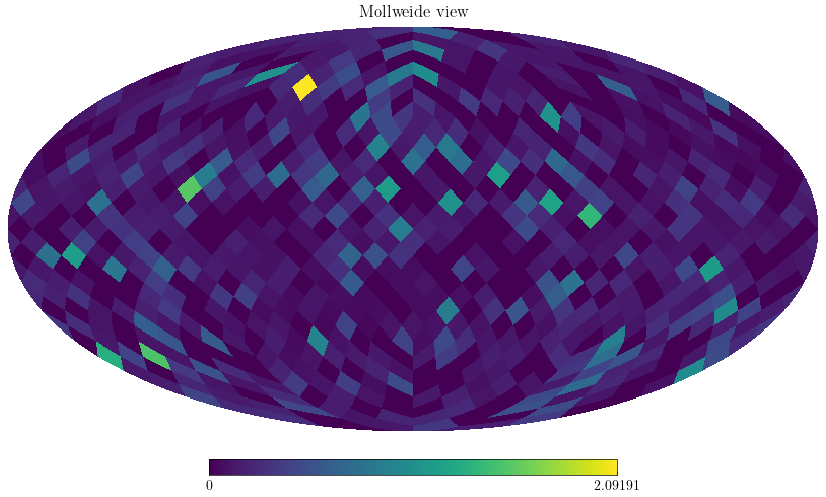

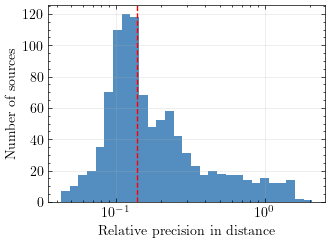

In [102]:
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
# Extract phi and theta coordinates for both Kerr and Source directions
# Kerr angular momentum direction
param_names = inference_metadata[(0, 'eccentric')]['param_names']
phi_K = inference_metadata[(0, 'eccentric')]['fish_params'][:,param_names.index('phiK')]
theta_K = inference_metadata[(0, 'eccentric')]['fish_params'][:,param_names.index('qK')]

# Source (sky) direction
phi_S = inference_metadata[(0, 'eccentric')]['fish_params'][:,param_names.index('phiS')]
theta_S = inference_metadata[(0, 'eccentric')]['fish_params'][:,param_names.index('qS')]

plot_on_sky = inference_metadata[(0, 'eccentric')]['snr']
plot_on_sky = inference_precision_data[(0, 'eccentric')]['relative_precision_dist']
# plot of SNR across the sky
plt.figure(figsize=(6,4))
nside = 8
npix = hp.nside2npix(nside)
sky_map = np.zeros(npix)
pixels = hp.ang2pix(nside, theta_S, phi_S)
# Accumulate the sum of errors in each pixel
for i, pix in enumerate(pixels):
    sky_map[pix] += plot_on_sky[i]
counts = np.bincount(pixels, minlength=npix)
counts[counts == 0] = 1  # avoid division by zero
sky_map = sky_map / counts  # average error per pixel
hp.mollview(sky_map)#, title=f"Precision error across sky for {el}", unit="Error", cmap="viridis")
plt.tight_layout()
plt.show()

# histogram of precision
plt.figure()
bins = np.logspace(np.log10(np.min(plot_on_sky)), np.log10(np.max(plot_on_sky)), 30)
plt.hist(plot_on_sky, bins=bins, histtype='stepfilled', alpha=0.7)
plt.axvline(np.median(plot_on_sky), color='r', linestyle='dashed', linewidth=1, label='Median')
plt.xlabel("Relative precision in distance")
plt.ylabel("Number of sources")
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [162]:
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
key_source = (20, 'circular')
# Extract phi and theta coordinates for both Kerr and Source directions
param_names = inference_metadata[key_source]['param_names']
# Kerr angular momentum direction
phi_K = inference_metadata[key_source]['fish_params'][:,param_names.index('phiK')]
theta_K = inference_metadata[key_source]['fish_params'][:,param_names.index('qK')]

# Source (sky) direction
phi_S = inference_metadata[key_source]['fish_params'][:,param_names.index('phiS')]
theta_S = inference_metadata[key_source]['fish_params'][:,param_names.index('qS')]
# plt.plot(theta_S/np.pi,phi_S/(2*np.pi),'.')

/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_97978/1128114542.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

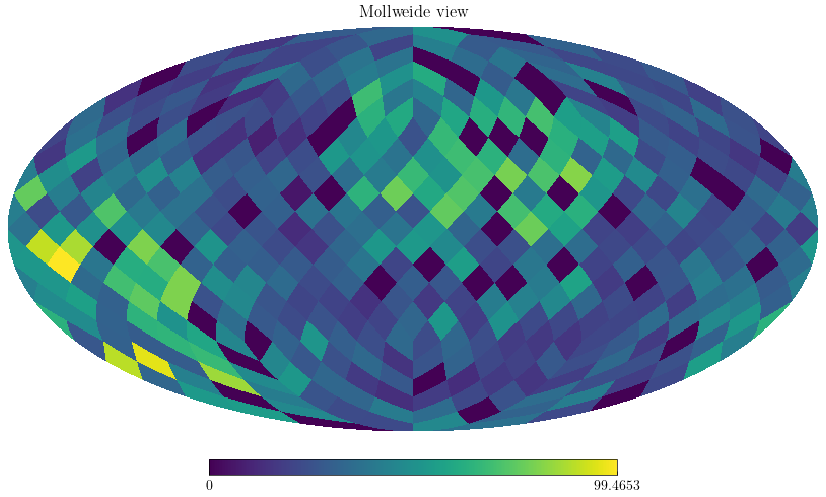

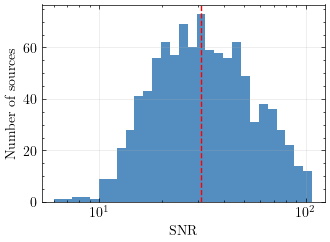

In [165]:
plot_on_sky = inference_metadata[key_source]['snr']
# plot_on_sky = inference_precision_data[key_source]['relative_precision_dist']
# plot of SNR across the sky
plt.figure(figsize=(6,4))
nside = 6
npix = hp.nside2npix(nside)
sky_map = np.zeros(npix)
pixels = hp.ang2pix(nside, theta_S, phi_S)
# Accumulate the sum of errors in each pixel
for i, pix in enumerate(pixels):
    sky_map[pix] += plot_on_sky[i]
counts = np.bincount(pixels, minlength=npix)
counts[counts == 0] = 1  # avoid division by zero
sky_map = sky_map / counts  # average error per pixel
hp.mollview(sky_map)#, title=f"Precision error across sky for {el}", unit="Error", cmap="viridis")
plt.tight_layout()
plt.show()

# histogram of precision
plt.figure()
bins = np.logspace(np.log10(np.min(plot_on_sky)), np.log10(np.max(plot_on_sky)), 30)
plt.hist(plot_on_sky, bins=bins, histtype='stepfilled', alpha=0.7)
plt.axvline(np.median(plot_on_sky), color='r', linestyle='dashed', linewidth=1, label='Median')
plt.xlabel("SNR")
plt.ylabel("Number of sources")
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

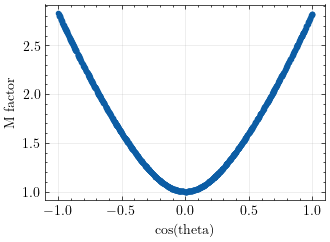

/var/folders/78/stbtx34d7vj939lq8bmh39wrx379gb/T/ipykernel_97978/2832108257.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

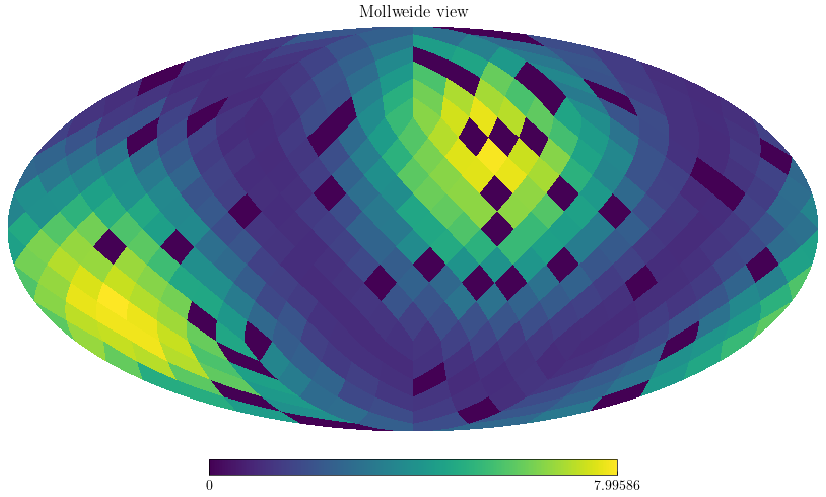

In [231]:
# https://arxiv.org/pdf/0710.5250
t0 = 0.4
cos_theta = 0.5 * np.cos(theta_S) - np.sqrt(3)/2 * np.sin(theta_S) * np.cos(2*np.pi*t0-phi_S)
M = 1 + 6 * cos_theta**2 + cos_theta**4
plt.figure()
plt.plot(cos_theta,M**0.5,'.')
plt.xlabel('cos(theta)')
plt.ylabel('M factor')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
nside = 6
npix = hp.nside2npix(nside)
sky_map = np.zeros(npix)
pixels = hp.ang2pix(nside, theta_S, phi_S)
# Accumulate the sum of errors in each pixel
for i, pix in enumerate(pixels):
    sky_map[pix] += M[i]
counts = np.bincount(pixels, minlength=npix)
counts[counts == 0] = 1  # avoid division by zero
sky_map = sky_map / counts  # average error per pixel
hp.mollview(sky_map)#, title=f"Precision error across sky for {el}", unit="Error", cmap="viridis")
plt.tight_layout()
plt.show()


(20, 'circular') 1000000.0 100.0


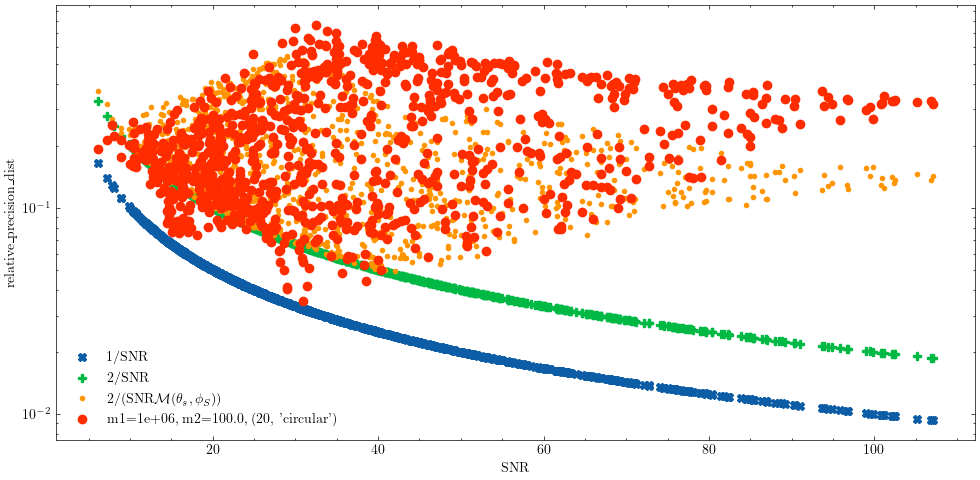

In [252]:
# plot relative precision histogram on m1 for inference_precision_data
plt.figure(figsize=(10,5))

for idx, run_type in enumerate(['circular']):
    relative_precisions = []
    for src_key in inference_precision_data:
        
        if (src_key[1] == run_type)and(inference_metadata[src_key]['T']>4.0)and(inference_metadata[src_key]['a']>0.0)and(np.abs(1-inference_metadata[src_key]['m1']/1e6)<1e-6)and(np.abs(1-inference_metadata[src_key]['m2']/100)<1e-6):
            print(src_key, inference_metadata[src_key]['m1'], inference_metadata[src_key]['m2'])
            label = f"m1={inference_metadata[src_key]['m1']:.0e}, m2={inference_metadata[src_key]['m2']}, {src_key}"
            
            
            param_names = inference_metadata[key_source]['param_names']
            # Source (sky) direction
            phi_S = inference_metadata[key_source]['fish_params'][:,param_names.index('phiS')]
            theta_S = inference_metadata[key_source]['fish_params'][:,param_names.index('qS')]
            t0 = 0.4
            cos_theta = 0.5 * np.cos(theta_S) - np.sqrt(3)/2 * np.sin(theta_S) * np.cos(2*np.pi*t0-phi_S)
            power_factor = 1 + 6 * cos_theta**2 + cos_theta**4
            # power_factor /= power_factor.min()
            # plt.semilogy(inference_metadata[src_key]['snr'], (inference_precision_data[src_key]['relative_precision_dist']*power_factor),  '.')
            plt.semilogy(inference_metadata[src_key]['snr'], 1/inference_metadata[src_key]['snr'],  'X', label='1/SNR')
            plt.semilogy(inference_metadata[src_key]['snr'], 2/inference_metadata[src_key]['snr'],  'P', label='2/SNR')
            plt.semilogy(inference_metadata[src_key]['snr'], 2*power_factor/(inference_metadata[src_key]['snr']),  '.',label=r'$2/(\mathrm{SNR} \mathcal{M}(\theta_s,\phi_S))$')
            plt.semilogy(inference_metadata[src_key]['snr'], inference_precision_data[src_key]['relative_precision_dist'],  'o', label=label)

plt.legend(loc='lower left')
plt.ylabel('relative_precision_dist')
plt.xlabel('SNR')
plt.tight_layout()
plt.show()

In [35]:
# Create widgets for measurement precision plot
spin_dropdown_inf = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values_inf],
    description='Spin (a):',
    value=a_values_inf[-1] if a_values_inf else None
)

tpl_dropdown_inf = Dropdown(
    options=[(f'Tpl = {t:.2f}', t) for t in tpl_values_inf],
    description='Tpl:',
    value=tpl_values_inf[0] if tpl_values_inf else None
)

m2_filter_inf = Dropdown(
    options=[('All', 'all')] + [(f'm2 = {m2:.0f}', m2) for m2 in sorted(m2_values_inf)],
    description='Secondary mass:',
    value='all'
)

run_type_filter_inf = Dropdown(
    options=[('All', 'all'), ('Circular', 'circular'), ('Eccentric', 'eccentric')],
    description='Run type:',
    value='circular'
)
options = [
        ('Relative m1 (detector)', 'relative_precision_m1_det'),
        ('Relative m1 (source)', 'relative_precision_m1'),
        ('Relative m2 (detector)', 'relative_precision_m2_det'),
        ('Relative m2 (source)', 'relative_precision_m2'),
        ('Relative distance', 'relative_precision_dist'),
        ('Relative e0', 'relative_precision_e0'),
        ('Absolute a', 'absolute_precision_a'),
        ('Absolute OmegaS', 'absolute_precision_OmegaS'),
    ]
precision_metric_inf = Dropdown(
    options=options,
    description='Metric:',
    value='relative_precision_m1'
)

output_inf_plot = Output()

ylabel_map = {
    "relative_precision_m1_det": r"$\sigma_{m_{ 1,\mathrm{det} } }/m_{ 1,\mathrm{det} }$",
    "relative_precision_m1": r"$\sigma_{m_{1} }/m_{1}$",
    "relative_precision_m2_det": r"$\sigma_{m_{ 2,\mathrm{det} } }/m_{ 2,\mathrm{det} }$",
    "relative_precision_m2": r"$\sigma_{m_{2} }/m_{2}$",
    "relative_precision_dist": r"$\sigma_{d_L}/d_L$",
    "relative_precision_e0": r"$\sigma_{e_0}/e_0$",
    "absolute_precision_a":  r"$\sigma_{a}$",
    "absolute_precision_OmegaS": r"$\Delta \Omega_S$",
}

ylabel_map["relative_precision_m1_det"]



'$\\sigma_{m_{ 1,\\mathrm{det} } }/m_{ 1,\\mathrm{det} }$'

In [36]:
def plot_measurement_precision(spin_a, tpl_val, m2_filter, run_type_filter, precision_metric, degradation):
    """
    Plot measurement precision vs m1 for inference analysis.
    Shows effect of detector degradation on parameter estimation precision.
    Handles both 'circular' and 'eccentric' runs with different precision metrics.
    Single panel: Measurement Precision vs m1 with degradation effect
    """
    tolerance = 1e-6
    precision_data = {}
    
    for src_key in sorted(inference_metadata.keys()):
        source_id, run_type = src_key
        
        # Filter by spin and Tpl
        src_a = inference_metadata[src_key]['a']
        src_tpl = inference_metadata[src_key]['T']
        if abs(src_a - spin_a) > tolerance or abs(src_tpl - tpl_val) > tolerance:
            continue
        
        # Filter by run_type if specified
        if run_type_filter != 'all' and run_type != run_type_filter:
            continue
        
        m1 = inference_metadata[src_key]['m1']
        m2 = inference_metadata[src_key]['m2']
        
        # Check if this precision metric exists for this source
        if precision_metric not in inference_precision_data[src_key]:
            continue
        
        # Get precision array and compute median (across 100 realizations)
        precision_array = inference_precision_data[src_key][precision_metric]  # shape (100,)
        precision_orig = estimator(precision_array)
        precision_deg = precision_orig * np.sqrt(degradation)  # Degradation increases uncertainty
        
        # Create a unique key combining m2 and run_type for legend
        data_key = (m2, run_type)
        
        if data_key not in precision_data:
            precision_data[data_key] = {'m1': [], 'precision_orig': [], 'precision_deg': []}
        
        precision_data[data_key]['m1'].append(m1)
        precision_data[data_key]['precision_orig'].append(precision_orig)
        precision_data[data_key]['precision_deg'].append(precision_deg)
    
    # Create figure with single subplot
    with output_inf_plot:
        output_inf_plot.clear_output(wait=True)
        
        if not precision_data:
            print(f"No data found for spin a={spin_a:.2f}, Tpl={tpl_val:.2f} and metric {precision_metric}")
            return
        
        fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
        
        # Get unique m2 values and create colormap
        all_m2_values_inf = sorted(set(m2 for m2, _ in precision_data.keys()))
        colors_inf = plt.cm.tab20(np.linspace(0, 1, len(all_m2_values_inf)))
        m2_to_color_inf = {m2: colors_inf[idx] for idx, m2 in enumerate(all_m2_values_inf)}
        
        # PLOT: Measurement Precision vs m1 with degradation arrows
        for (m2, run_type) in sorted(precision_data.keys()):
            # Filter by m2 if user selected specific value
            if m2_filter != 'all' and m2 != m2_filter:
                continue
            
            m1_vals = np.array(precision_data[(m2, run_type)]['m1'])
            precision_orig = np.array(precision_data[(m2, run_type)]['precision_orig'])
            precision_deg = np.array(precision_data[(m2, run_type)]['precision_deg'])
            
            sort_idx = np.argsort(m1_vals)
            m1_sorted = m1_vals[sort_idx]
            precision_orig_sorted = precision_orig[sort_idx]
            precision_deg_sorted = precision_deg[sort_idx]
            
            color = m2_to_color_inf[m2]
            linestyle = '-'# if run_type == 'circular' else '-.'
            marker = 'o'# if run_type == 'circular' else '^'
            
            # Plot original and degraded measurement precision
            ax1.plot(m1_sorted, precision_orig_sorted, marker=marker, linestyle=linestyle, color=color,
                    markersize=7, linewidth=1.5, label=f'${m2:.0f}$', alpha=0.7)
            ax1.plot(m1_sorted, precision_deg_sorted, 's', linestyle='--', color=color,
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw upward arrows showing degradation (precision gets worse)
            for i in range(len(m1_sorted)):
                ax1.annotate('', xy=(m1_sorted[i], precision_deg_sorted[i]),
                           xytext=(m1_sorted[i], precision_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=color,
                                         lw=1.5, alpha=0.6))
        
        ax1.set_xlabel(r'Primary mass $m_1 [M_\odot]$', )
        # print(ylabel_map[precision_metric])
        # ax1.set_ylabel(f'{precision_metric}')
        ax1.set_ylabel(ylabel_map[precision_metric])
        
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major')
        
        # First legend for m2 values and run types
        leg1 = ax1.legend(loc='upper center', ncols=4, frameon=True, 
                          title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        # ax1.set_ylim(None, 10)
        
        # Second legend for line styles
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=f'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, loc='lower right', frameon=True)
        ax1.add_artist(leg2)
        
        plt.tight_layout()
        plt.savefig('precision_vs_m1_' + precision_metric + '.png', dpi=300)
        plt.show()


In [37]:
# Display controls and plot
controls_inf = HBox([spin_dropdown_inf, tpl_dropdown_inf, m2_filter_inf, run_type_filter_inf, precision_metric_inf, degradation_slider])
display(controls_inf)
display(output_inf_plot)

# Create interactive plot
_ = interact(plot_measurement_precision, spin_a=spin_dropdown_inf, tpl_val=tpl_dropdown_inf,
             m2_filter=m2_filter_inf, run_type_filter=run_type_filter_inf, 
             precision_metric=precision_metric_inf, degradation=degradation_slider)


Output()

interactive(children=(Dropdown(description='Spin (a):', index=1, options=(('a = -0.99', -0.99), ('a = 0.99', 0…

# Improvement due to eccentricity

In [19]:
def plot_measurement_precision_ratio(spin_a, tpl_val, m2_filter, precision_metric, degradation):
    """
    Plot ratio of eccentric to circular measurement precision vs m1.
    Shows how much better (or worse) eccentric orbits perform relative to circular orbits.
    Ratio > 1 means eccentric is worse (larger errors)
    Ratio < 1 means eccentric is better (smaller errors)
    """
    tolerance = 1e-6
    precision_data_ratio = {}
    
    for src_key in sorted(inference_metadata.keys()):
        source_id, run_type = src_key
        
        # Filter by spin and Tpl
        src_a = inference_metadata[src_key]['a']
        src_tpl = inference_metadata[src_key]['T']
        if abs(src_a - spin_a) > tolerance or abs(src_tpl - tpl_val) > tolerance:
            continue
        
        m1 = inference_metadata[src_key]['m1']
        m2 = inference_metadata[src_key]['m2']
        
        # Check if this precision metric exists for this source
        if precision_metric not in inference_precision_data[src_key]:
            continue
        
        # Get precision array and compute median (across 100 realizations)
        precision_array = inference_precision_data[src_key][precision_metric]
        precision_orig = np.median(precision_array)
        precision_deg = precision_orig * np.sqrt(degradation)
        
        # Store by m2 with run_type
        if m2 not in precision_data_ratio:
            precision_data_ratio[m2] = {'m1': [], 'circular': [], 'eccentric': []}
        
        if run_type == 'circular':
            precision_data_ratio[m2]['m1'].append(m1)
            precision_data_ratio[m2]['circular'].append(precision_deg)
        elif run_type == 'eccentric':
            precision_data_ratio[m2]['m1'].append(m1)
            precision_data_ratio[m2]['eccentric'].append(precision_deg)
    
    # Calculate ratios
    ratio_data = {}
    for m2 in precision_data_ratio:
        if len(precision_data_ratio[m2]['circular']) > 0 and len(precision_data_ratio[m2]['eccentric']) > 0:
            # Match m1 values between circular and eccentric
            circ_dict = {m1: prec for m1, prec in zip(precision_data_ratio[m2]['m1'][:len(precision_data_ratio[m2]['circular'])], 
                                                       precision_data_ratio[m2]['circular'])}
            ecc_dict = {m1: prec for m1, prec in zip(precision_data_ratio[m2]['m1'][len(precision_data_ratio[m2]['circular']):], 
                                                      precision_data_ratio[m2]['eccentric'])}
            
            # Find common m1 values
            common_m1 = set(circ_dict.keys()) & set(ecc_dict.keys())
            if common_m1:
                m1_vals = sorted(common_m1)
                ratio_data[m2] = {
                    'm1': m1_vals,
                    'ratio': [ecc_dict[m1] / circ_dict[m1] for m1 in m1_vals]
                }
    
    # Create figure
    with output_inf_plot:
        output_inf_plot.clear_output(wait=True)
        
        if not ratio_data:
            print(f"No data found for spin a={spin_a:.2f}, Tpl={tpl_val:.2f} and metric {precision_metric}")
            return
        
        fig, ax = plt.subplots(1, 1, figsize=(5,5))
        
        # Get unique m2 values and create colormap
        all_m2_values = sorted(set(ratio_data.keys()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(all_m2_values)))
        m2_to_color = {m2: colors[idx] for idx, m2 in enumerate(all_m2_values)}
        
        # PLOT: Ratio vs m1
        for m2 in sorted(ratio_data.keys()):
            # Filter by m2 if user selected specific value
            if m2_filter != 'all' and m2 != m2_filter:
                continue
            
            m1_vals = np.array(ratio_data[m2]['m1'])
            ratio_vals = np.array(ratio_data[m2]['ratio'])
            
            sort_idx = np.argsort(m1_vals)
            m1_sorted = m1_vals[sort_idx]
            ratio_sorted = ratio_vals[sort_idx]
            
            color = m2_to_color[m2]
            
            # Plot ratio
            ax.plot(m1_sorted, ratio_sorted, 'o-', color=color,
                    markersize=7, linewidth=1.5, label=f'${m2:.0f}$', alpha=0.7)
        
        # Add horizontal line at y=1 for reference
        ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, alpha=0.5, label='No difference (ratio=1)')
        
        ax.set_xlabel(r'Primary mass $m_1 [M_\odot]$')
        ax.set_ylabel(r'Precision ratio $\sigma_{\mathrm{ecc}} / \sigma_{\mathrm{circ}}$')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major')
        
        # Legend for m2 values
        leg1 = ax.legend(loc='upper center', ncols=4, frameon=True, 
                         title=r'Secondary mass $m_2 [M_\odot]$')
        ax.add_artist(leg1)
        
        plt.tight_layout()
        plt.show()



In [34]:
# Create widgets for measurement precision ratio plot
spin_dropdown_ratio = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values_inf],
    description='Spin (a):',
    value=a_values_inf[-1] if a_values_inf else None
)

tpl_dropdown_ratio = Dropdown(
    options=[(f'Tpl = {t:.2f}', t) for t in tpl_values_inf],
    description='Tpl:',
    value=tpl_values_inf[0] if tpl_values_inf else None
)

m2_filter_ratio = Dropdown(
    options=[('All', 'all')] + [(f'm₂ = {m2:.0f}', m2) for m2 in sorted(m2_values_inf)],
    description='Secondary mass:',
    value='all'
)

precision_metric_ratio = Dropdown(
    options=options,
    description='Metric:',
    value='relative_precision_m1_det'
)

# Display controls and plot
controls_ratio = HBox([spin_dropdown_ratio, tpl_dropdown_ratio, m2_filter_ratio, 
                       precision_metric_ratio, degradation_slider])
display(controls_ratio)
display(output_inf_plot)

# Create interactive plot
_ = interact(plot_measurement_precision_ratio, spin_a=spin_dropdown_ratio, tpl_val=tpl_dropdown_ratio,
             m2_filter=m2_filter_ratio, precision_metric=precision_metric_ratio, 
             degradation=degradation_slider)


Output()

NameError: name 'plot_measurement_precision_ratio' is not defined

# Mission lifetime

In [27]:

def plot_measurement_precision_vs_tpl(m1_val, spin_a, run_type_filter, precision_metric, degradation):
    """
    Plot measurement precision as a function of Tpl for fixed m1 and all m2 values.
    Similar structure to plot_snr_redshift_vs_tpl but for measurement precision.
    
    Top: Measurement Precision vs Tpl (with degradation effect)
    Bottom: [Optional] Could add another metric or redshift reach
    """
    tolerance = 1e-6
    precision_data_tpl = {}
    
    for src_key in sorted(inference_metadata.keys()):
        source_id, run_type = src_key
        
        # Filter by m1 and spin
        src_a = inference_metadata[src_key]['a']
        src_m1 = inference_metadata[src_key]['m1']
        
        if abs(src_a - spin_a) > tolerance or abs(src_m1 - m1_val) > tolerance:
            continue
        
        # Filter by run_type if specified
        if run_type_filter != 'all' and run_type != run_type_filter:
            continue
        
        tpl = inference_metadata[src_key]['T']
        m2 = inference_metadata[src_key]['m2']
        
        # Check if this precision metric exists for this source
        if precision_metric not in inference_precision_data[src_key]:
            continue
        
        # Get precision array and compute median (across 100 realizations)
        precision_array = inference_precision_data[src_key][precision_metric]  # shape (100,)
        precision_orig = estimator(precision_array)
        precision_deg = precision_orig * np.sqrt(degradation)  # Degradation increases uncertainty
        
        if m2 not in precision_data_tpl:
            precision_data_tpl[m2] = {'tpl': [], 'precision_orig': [], 'precision_deg': []}
        
        precision_data_tpl[m2]['tpl'].append(tpl)
        precision_data_tpl[m2]['precision_orig'].append(precision_orig)
        precision_data_tpl[m2]['precision_deg'].append(precision_deg)
    
    # Create figure with single subplot (measurement precision vs Tpl)
    with output_inf_plot:
        output_inf_plot.clear_output(wait=True)
        
        if not precision_data_tpl:
            print(f"No data found for m1={m1_val:.0e}, a={spin_a:.2f} and metric {precision_metric}")
            return
        
        fig, ax1 = plt.subplots(1, 1, figsize=(5,5))
        
        # Get unique m2 values and create colormap using global m2_values
        all_m2_values_tpl = sorted(set(precision_data_tpl.keys()))
        colors = plt.cm.tab20(np.linspace(0, 1, len(m2_values)))
        m2_to_color_tpl = {m2: colors[m2_values.index(m2)] if m2 in m2_values else colors[0] 
                           for m2 in all_m2_values_tpl}
        
        # PLOT: Measurement Precision vs Tpl with degradation arrows
        for m2 in sorted(precision_data_tpl.keys()):
            tpl_vals = np.array(precision_data_tpl[m2]['tpl'])
            precision_orig = np.array(precision_data_tpl[m2]['precision_orig'])
            precision_deg = np.array(precision_data_tpl[m2]['precision_deg'])
            
            sort_idx = np.argsort(tpl_vals)
            tpl_sorted = tpl_vals[sort_idx]
            precision_orig_sorted = precision_orig[sort_idx]
            precision_deg_sorted = precision_deg[sort_idx]
            
            color = m2_to_color_tpl[m2]
            
            # Plot original and degraded measurement precision
            ax1.plot(tpl_sorted, precision_orig_sorted, 'o-', color=color,
                    markersize=7, linewidth=1.5, label=f'${m2:.0f}$', alpha=0.7)
            ax1.plot(tpl_sorted, precision_deg_sorted, 's--', color=color,
                    markersize=6, linewidth=1.5, alpha=0.5)
            
            # Draw upward arrows showing degradation (precision gets worse)
            for i in range(len(tpl_sorted)):
                ax1.annotate('', xy=(tpl_sorted[i], precision_deg_sorted[i]),
                           xytext=(tpl_sorted[i], precision_orig_sorted[i]),
                           arrowprops=dict(arrowstyle='->', color=color,
                                         lw=1.5, alpha=0.6))
        
        ax1.set_xlabel(r'Plunge time $T_{{pl}} [\mathrm{yr}]$', fontsize=10)
        ax1.set_ylabel(ylabel_map[precision_metric], fontsize=10)
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major', labelsize=9)
        
        # First legend for m2 values
        leg1 = ax1.legend(loc='upper center', ncols=4, frameon=True, 
                          title=r'Secondary mass $m_2 [M_\odot]$')
        ax1.add_artist(leg1)
        
        # Second legend for line styles
        legend_elements = [Line2D([0], [0], marker='o', label=f'Current sensitivity',
                                  markerfacecolor='gray', markersize=7, linestyle='-', color='gray'),
                          Line2D([0], [0], marker='s', label=rf'Degraded by $d={degradation:.1f}$',
                                  markerfacecolor='gray', markersize=6, linestyle='--', color='gray')]
        leg2 = ax1.legend(handles=legend_elements, loc='lower right', frameon=True)
        ax1.add_artist(leg2)
        
        plt.tight_layout()
        plt.savefig('precision_vs_Tpl_' + precision_metric + '.png', dpi=300)

        plt.show()


In [28]:
options

[('Relative m1 (detector)', 'relative_precision_m1_det'),
 ('Relative m1 (source)', 'relative_precision_m1'),
 ('Relative m2 (detector)', 'relative_precision_m2_det'),
 ('Relative m2 (source)', 'relative_precision_m2'),
 ('Relative distance', 'relative_precision_dist'),
 ('Relative e0', 'relative_precision_e0'),
 ('Absolute a', 'absolute_precision_a'),
 ('Absolute OmegaS', 'absolute_precision_OmegaS')]

In [29]:

# Create widgets for measurement precision vs Tpl plot
m1_filtered_inf = [m1 for m1 in sorted(set(inference_metadata[src]['m1'] for src in inference_metadata)) 
                   if m1 in [1e6, 1e7]]

m1_dropdown_precision_tpl = Dropdown(
    options=[(f'm₁ = {m1:.0e}', m1) for m1 in m1_filtered_inf],
    description='Primary mass:',
    value=m1_filtered_inf[0] if m1_filtered_inf else None
)

spin_dropdown_precision_tpl = Dropdown(
    options=[(f'a = {a:.2f}', a) for a in a_values_inf],
    description='Spin (a):',
    value=a_values_inf[-1] if a_values_inf else None
)

run_type_filter_precision_tpl = Dropdown(
    options=[('All', 'all'), ('Circular', 'circular'), ('Eccentric', 'eccentric')],
    description='Run type:',
    value='eccentric'
)

precision_metric_precision_tpl = Dropdown(
    options=options,
    description='Metric:',
    value='relative_precision_m1_det'
)

# Display controls and plot
controls_precision_tpl = HBox([m1_dropdown_precision_tpl, spin_dropdown_precision_tpl, 
                               run_type_filter_precision_tpl, precision_metric_precision_tpl, 
                               degradation_slider])
display(controls_precision_tpl)
display(output_inf_plot)

# Create interactive plot
_ = interact(plot_measurement_precision_vs_tpl, m1_val=m1_dropdown_precision_tpl,
             spin_a=spin_dropdown_precision_tpl, run_type_filter=run_type_filter_precision_tpl,
             precision_metric=precision_metric_precision_tpl, degradation=degradation_slider)


Output()

interactive(children=(Dropdown(description='Primary mass:', options=(('m₁ = 1e+06', 1000000.0), ('m₁ = 1e+07',…